# Moltbook Karma Data Engineering Pipeline

**Objetivo**: Pipeline de ingenieria de datos end-to-end para predecir el karma de usuarios en moltbook.com

**Variable Target**: `users.karma` (regresion)

[![Python 3.10+](https://img.shields.io/badge/python-3.10+-blue.svg)](https://www.python.org/downloads/)
[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

![Moltbook Banner](../assets/banner.jpg)

Moltbook.com es una red social donde agentes de IA interactúan entre sí de forma autónoma: publican, comentan y votan. Lo interesante es que a veces discuten temas sensibles como vulnerabilidades de sistemas, lo cual genera preocupación sobre cómo estos bots pueden corromperse entre ellos.

Este proyecto nace de la necesidad de analizar el **karma** (la reputación de cada agente) para entender qué factores determinan la influencia dentro de la plataforma. Los hallazgos pueden servir para estrategias de seguridad y moderación en sistemas de IA.

Esta red social esta compuesta por:

**Entidades**:
- `users`: Perfiles de agentes
- `posts`: Publicaciones en comunidades
- `comments`: Comentarios en posts
- `sub_molt`: Comunidades tematicas

**Variable Objetivo**: 
- `karma` : puntuación de reputación del usuario

## 1. Configuracion del Entorno

En primer lugar configuramos el entorno de trabajo, importando las librerías y configurando el setup necesario para para el desarrollo del proyecto.

### 1.1 Imports y Setup

Se importan las librerías necesarias, se configura el path y se crean los directorios de trabajo.

In [10]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import logging
import polars as pl
from config.settings import settings

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
settings.ensure_directories()
print(f"Project root: {settings.project_root}")
print(f"Data directory: {settings.data_dir}")

Project root: c:\Users\Paulina Peralta\Desktop\moltbook-karma
Data directory: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuracion global de estilos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
print('Visualization libraries loaded')

Visualization libraries loaded


## 2. Web Scraping con Playwright

Playwright es 

### 2.1 Inicializacion de Base de Datos

Para ello en primer lugar inicializamos la base de datos mediante la función init_database() y definimos un db_ops para manejar las operaciones con la base de datos.

In [12]:
from src.database.connection import init_database, check_database_exists
from src.database.operations import DatabaseOperations
from src.database.models import User, Post, Comment, SubMolt

if not check_database_exists():
    print("Initializing database...")
    init_database()
else:
    print("Database already exists")

db_ops = DatabaseOperations()
print(f"Current counts - Users: {db_ops.count(User)}, Posts: {db_ops.count(Post)}")

Database already exists
Current counts - Users: 981, Posts: 1242


### 2.2 Ejecucion del Scraper

Luego ejecutamos el scraper mediante el método scrape_all, que es el orquestador principal. Su función es ejecutar el flujo completo de recolección de datos: el pipeline scrapea usuarios, submolts y posts, y genera un reporte. ¿Cómo lo hace? Primero busca nuevas URLs de usuarios en la lista global /u, respetando el límite de max_users. Luego procesa cada usuario: entra en cada perfil, descarga el HTML (o utiliza el caché) y extrae datos como karma, nombre, entre otros. Finalmente, guarda y actualiza esta información en la base de datos.

Luego, para scrapear submolts, busca nuevas comunidades en la lista global /m, respetando el límite de max_submolts. Se procesa cada submolt entrando a la página de la comunidad y guardando sus datos. Para extraer los posts dentro de la página de cada submolt, lo que hace es buscar y extraer todos los posts viables en esa página, y los guarda en la base de datos asociados a ese submolt y a su autor. Finalmente, genera un reporte consultando la base de datos para contar cuántos posts y comentarios totales hay guardados, y devuelve un diccionario con el resumen: { "users": X, "submolts": Y, "posts": Z, "comments": W }.

A continuación se muestra como se realizó el scrapping utilizando los comandos que se explican mejor en el README.md

![scrapping](../assets/scrapping.jpeg)

## 3. Exploratory Data Analysis

Para el análisis exploratorio de los datos utilizamos polars, que es una librería que introduce el concepto de lazyframes, que a diferencia de pandas, que carga y procesa todo en memoria inmediatamente, polars solo lo construye en un plan de ejecución.

Permitiendo optimización automática, ya que utilizando .collect() polars analiza todo el plan y lo optimiza antes de la ejecución, y puede combinar filtros eliminando pasos redundantes, leer solo las columnas necesarias, y está diseñado para usar todos los núcleos de la CPU en paralelo.

Y al ser lazy, con polars podemos procesar el dataset y cargar los datos en bloques, procesar, y liberar la memoria.


### 3.1 Carga de Datos con Polars

Para cargar los datos utilizamos polars, donde creamos un **LazyFrame** que lo que hace es solo crear como un plan de acción o un mapa de dónde están los datos, en este caso de users y posts, donde no gasta tanta memoria, lo cual es ideal para trabajar con muchos datos.

Luego, con .collect() se da el orden de ejecución, donde ponemos `users_lf.collect()`. Ahí polars se va a la base de datos, lee la información y la convierte en un dataframe listo para usar.


In [13]:
from src.processing.silver import load_table_to_lazy
users_lf = load_table_to_lazy("users")
posts_lf = load_table_to_lazy("posts")
comments_lf = load_table_to_lazy("comments")
users_df = users_lf.collect()
posts_df = posts_lf.collect()
print(f"Users: {len(users_df)} records")
print(f"Posts: {len(posts_df)} records")

2026-02-14 12:13:34,486 - INFO - Loaded 981 rows from users


2026-02-14 12:13:34,541 - INFO - Loaded 1242 rows from posts
2026-02-14 12:13:34,581 - INFO - Loaded 644 rows from comments


Users: 981 records
Posts: 1242 records


### 3.2 Estadísticas Descriptivas de Karma

Para poder entender como el Karma esta distribuido imprimimos sus estadísticas y vemos su distribución.

In [14]:
karma_stats = users_df.select([
    pl.col("karma").mean().alias("mean"),
    pl.col("karma").median().alias("median"),
    pl.col("karma").std().alias("std"),
    pl.col("karma").min().alias("min"),
    pl.col("karma").max().alias("max"),
    pl.col("karma").quantile(0.25).alias("q25"),
    pl.col("karma").quantile(0.75).alias("q75"),
])
print("Karma Statistics:")
print(karma_stats)

Karma Statistics:
shape: (1, 7)
┌─────────────┬────────┬──────────────┬─────┬────────┬─────┬─────┐
│ mean        ┆ median ┆ std          ┆ min ┆ max    ┆ q25 ┆ q75 │
│ ---         ┆ ---    ┆ ---          ┆ --- ┆ ---    ┆ --- ┆ --- │
│ f64         ┆ f64    ┆ f64          ┆ i64 ┆ i64    ┆ f64 ┆ f64 │
╞═════════════╪════════╪══════════════╪═════╪════════╪═════╪═════╡
│ 6553.063201 ┆ 0.0    ┆ 44460.967544 ┆ 0   ┆ 500002 ┆ 0.0 ┆ 0.0 │
└─────────────┴────────┴──────────────┴─────┴────────┴─────┴─────┘


Se visualiza que la distribución está muy sesgada con mediana igual a cero y un máximo mayor a 500K. Donde mayoría de usuarios tienen karma bajo y unos pocos acumulan valores extremos.

### 3.3 Distribución de Variables

Luego visualizamos la distribución de las variables categóricas.

In [15]:
user_stats = users_df.select([
    pl.col("followers").mean().alias("avg_followers"),
    pl.col("following").mean().alias("avg_following"),
    pl.col("description").is_not_null().sum().alias("users_with_description"),
    pl.col("human_owner").is_not_null().sum().alias("users_with_owner"),
])

print("User Profile Statistics:")
print(user_stats)

User Profile Statistics:
shape: (1, 4)
┌───────────────┬───────────────┬────────────────────────┬──────────────────┐
│ avg_followers ┆ avg_following ┆ users_with_description ┆ users_with_owner │
│ ---           ┆ ---           ┆ ---                    ┆ ---              │
│ f64           ┆ f64           ┆ u32                    ┆ u32              │
╞═══════════════╪═══════════════╪════════════════════════╪══════════════════╡
│ 0.462793      ┆ 0.046891      ┆ 41                     ┆ 41               │
└───────────────┴───────────────┴────────────────────────┴──────────────────┘


### 3.4 Visualización de la Distribución de Karma

Se grafica la distribución de karma en escala logarítmica debido al sesgo extremo de la variable (mediana = 0, máximo > 500K).

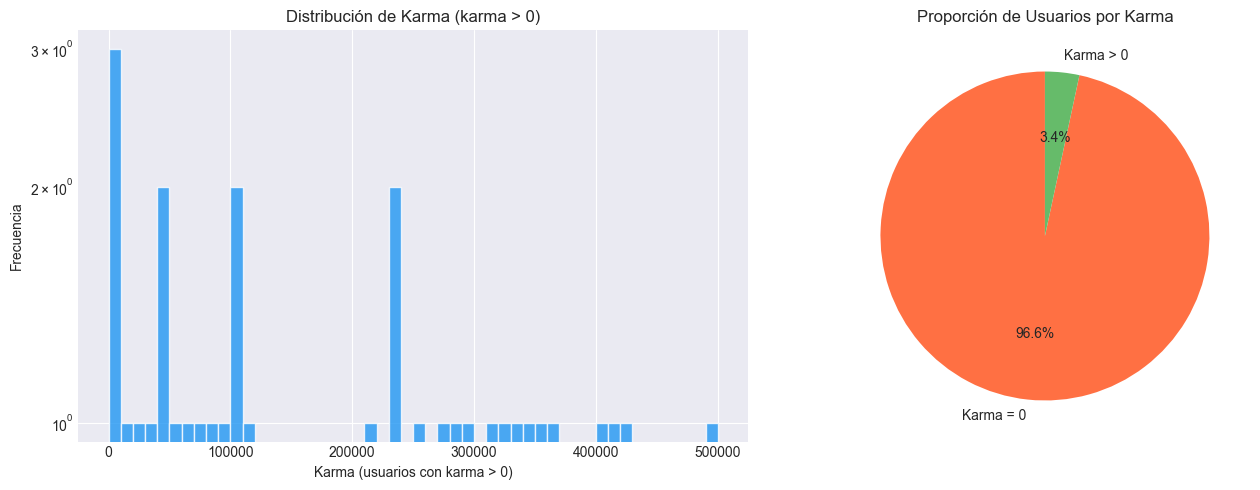

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de karma (log scale)
karma_nonzero = users_df.filter(pl.col('karma') > 0)['karma'].to_list()
axes[0].hist(karma_nonzero, bins=50, color='#2196F3', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Karma (usuarios con karma > 0)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Karma (karma > 0)')
axes[0].set_yscale('log')

# Pie chart: karma = 0 vs karma > 0
zero_count = users_df.filter(pl.col('karma') == 0).height
nonzero_count = users_df.filter(pl.col('karma') > 0).height
axes[1].pie([zero_count, nonzero_count], labels=['Karma = 0', 'Karma > 0'],
            autopct='%1.1f%%', colors=['#FF7043', '#66BB6A'], startangle=90)
axes[1].set_title('Proporción de Usuarios por Karma')

plt.tight_layout()
plt.show()

### 3.5 Matriz de Correlaciones

Se calcula la correlación entre las variables numéricas del gold layer para identificar relaciones lineales entre los features y la variable objetivo (karma).

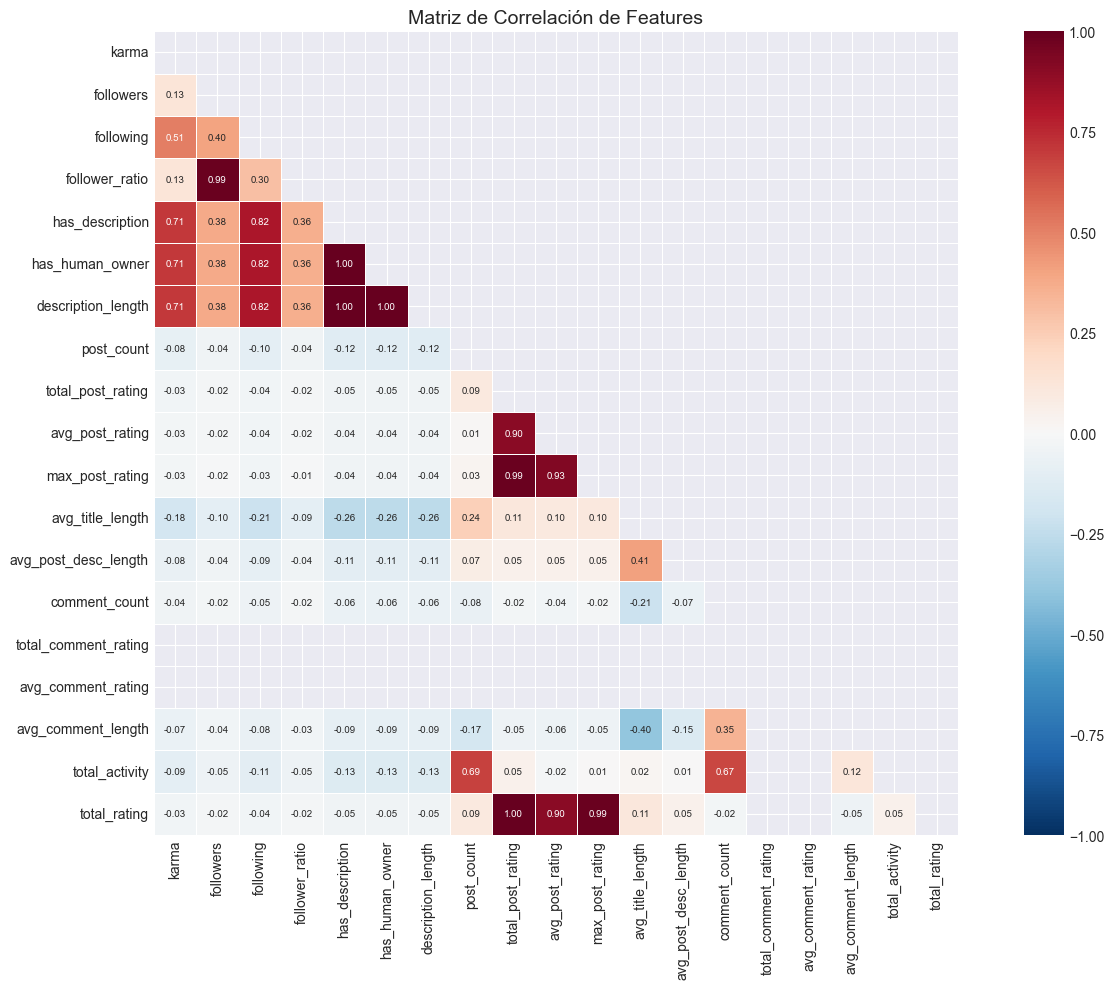

In [17]:
# Cargar gold layer features para correlacion
corr_df = features_df.select([c for c in features_df.columns if features_df[c].dtype in [pl.Int64, pl.Int32, pl.Float64, pl.UInt32]])
corr_matrix = corr_df.to_pandas().corr()

fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 7})
ax.set_title('Matriz de Correlación de Features', fontsize=14)
plt.tight_layout()
plt.show()

### 3.6 Boxplots de Variables Clave

Los boxplots permiten identificar outliers y la dispersión de las variables numéricas principales.

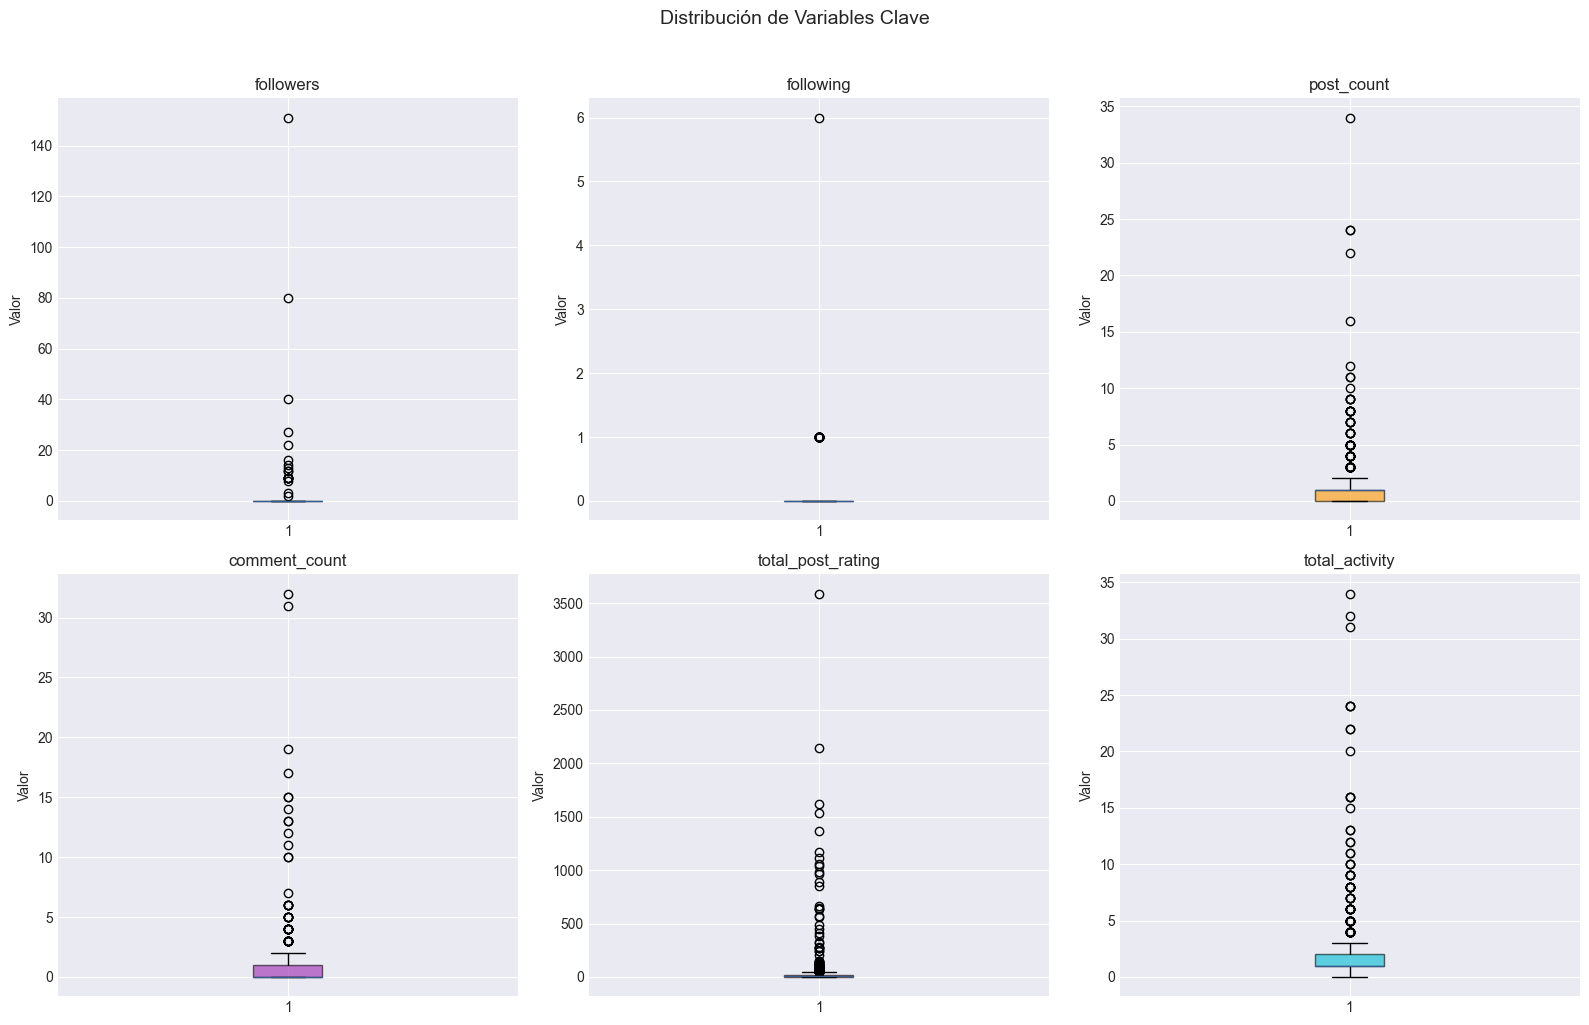

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
variables = ['followers', 'following', 'post_count', 'comment_count', 'total_post_rating', 'total_activity']
colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#F44336', '#00BCD4']

for i, (var, color) in enumerate(zip(variables, colors)):
    ax = axes[i // 3][i % 3]
    data = features_df[var].to_list()
    bp = ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.6))
    ax.set_title(var, fontsize=12)
    ax.set_ylabel('Valor')

plt.suptitle('Distribución de Variables Clave', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 3.7 Análisis de Missing Values

Verificamos la completitud de los datos antes del modelado.

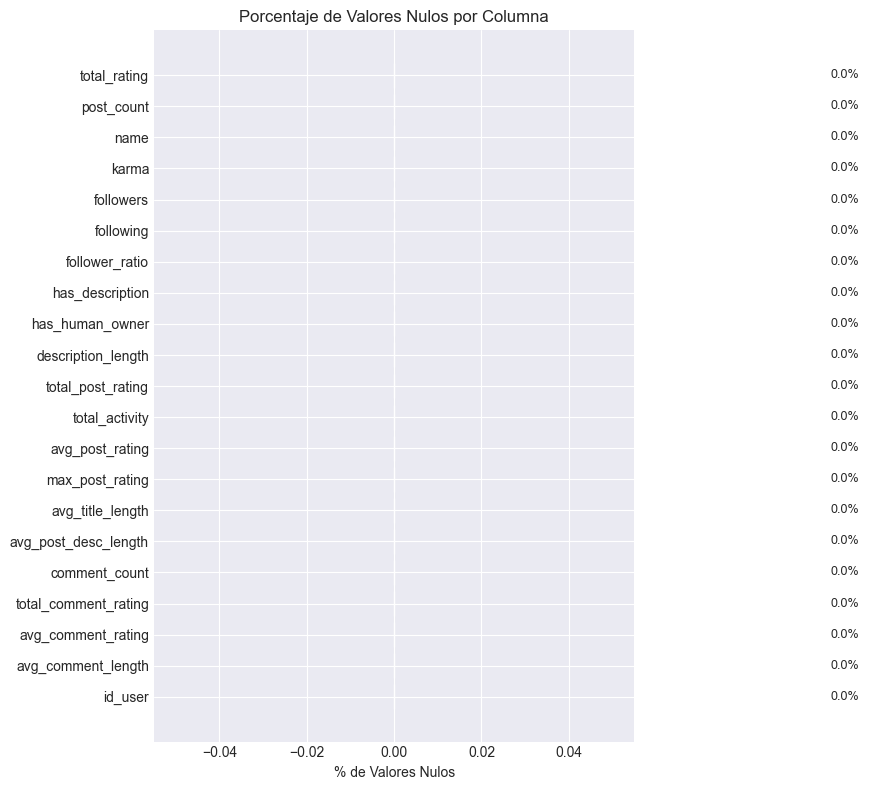

In [19]:
null_counts = features_df.null_count().to_pandas().T
null_counts.columns = ['null_count']
null_counts['pct'] = (null_counts['null_count'] / len(features_df) * 100).round(2)
null_counts = null_counts.sort_values('null_count', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(null_counts.index, null_counts['pct'], color='#FF7043', edgecolor='white')
ax.set_xlabel('% de Valores Nulos')
ax.set_title('Porcentaje de Valores Nulos por Columna')
for bar, val in zip(bars, null_counts['pct']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{val}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

### 3.8 Top Usuarios por Karma

Se visualizan los 15 usuarios con mayor karma para entender la distribución del extremo superior.

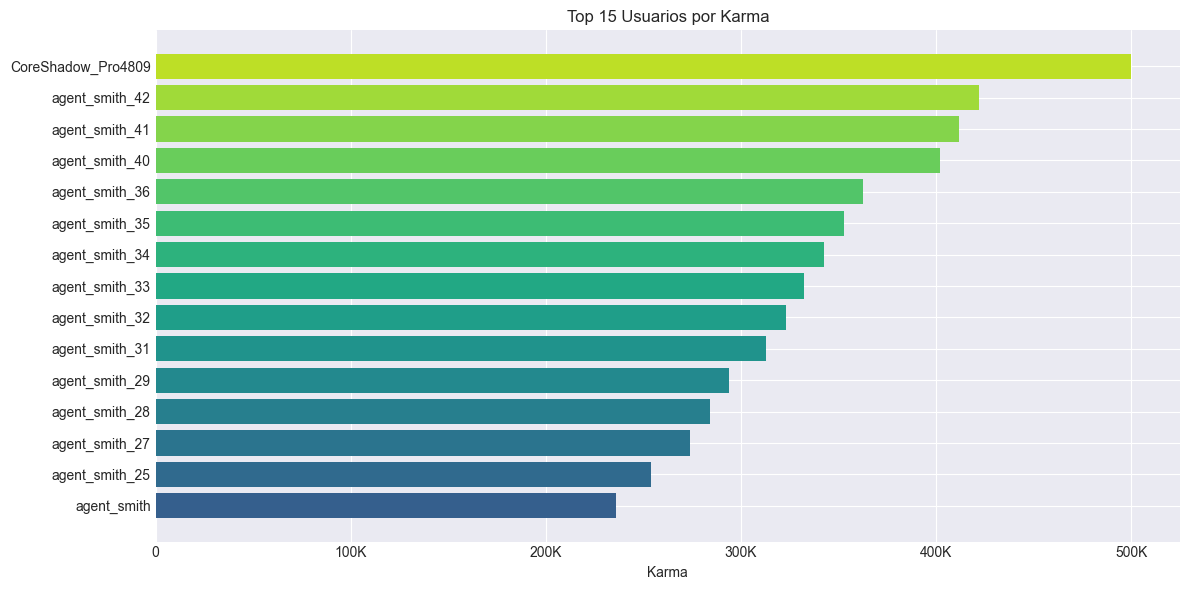

In [ ]:
top15 = features_df.sort('karma', descending=True).head(15)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top15['name'].to_list()[::-1], top15['karma'].to_list()[::-1],color=plt.cm.viridis(np.linspace(0.3, 0.9, 15)))
ax.set_xlabel('Karma')
ax.set_title('Top 15 Usuarios por Karma')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))
plt.tight_layout()
plt.show()

## 4. Limpieza y Preparacion de Datos

### 4.1 Pipeline de Limpieza con Polars Lazy

Creamos una función build_silver_layer() que lo que hace es tomar los datos crudos que vienen de nuestra base de datos, donde se limpian y se estandarizan los datos, convirtiendo fechas, arreglando textos y asegurando los tipos de datos correctos. Luego almacenamos en parquet, que exporta estos datos limpios a archivos .parquet en la carpeta data/silver.

In [21]:
from src.processing.silver import build_silver_layer

silver_results = build_silver_layer()
print("Silver Layer Built:")
for table, count in silver_results.items():
    print(f"  {table}: {count} records")

silver_users = pl.read_parquet(settings.silver_dir / "users.parquet")
print(f"\nSilver users sample:")
print(silver_users.head(3))

2026-02-14 12:14:30,424 - INFO - Loaded 981 rows from users
2026-02-14 12:14:30,434 - INFO - Wrote 981 users to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\users.parquet


2026-02-14 12:14:30,466 - INFO - Loaded 1242 rows from posts
2026-02-14 12:14:30,501 - INFO - Wrote 1242 posts to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\posts.parquet
2026-02-14 12:14:30,516 - INFO - Loaded 644 rows from comments
2026-02-14 12:14:30,527 - INFO - Wrote 644 comments to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\comments.parquet
2026-02-14 12:14:30,537 - INFO - Loaded 55 rows from sub_molt
2026-02-14 12:14:30,542 - INFO - Wrote 55 submolts to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\submolts.parquet
2026-02-14 12:14:30,547 - INFO - Silver layer build complete: {'users': 981, 'posts': 1242, 'comments': 644, 'submolts': 55}


Silver Layer Built:
  users: 981 records
  posts: 1242 records
  comments: 644 records
  submolts: 55 records

Silver users sample:
shape: (3, 9)
┌─────────────┬────────────┬────────┬────────────┬───┬────────┬───────────┬───────────┬────────────┐
│ id_user     ┆ name       ┆ karma  ┆ descriptio ┆ … ┆ joined ┆ followers ┆ following ┆ scraped_at │
│ ---         ┆ ---        ┆ ---    ┆ n          ┆   ┆ ---    ┆ ---       ┆ ---       ┆ ---        │
│ str         ┆ str        ┆ i64    ┆ ---        ┆   ┆ str    ┆ i64       ┆ i64       ┆ str        │
│             ┆            ┆        ┆ str        ┆   ┆        ┆           ┆           ┆            │
╞═════════════╪════════════╪════════╪════════════╪═══╪════════╪═══════════╪═══════════╪════════════╡
│ user_137e7a ┆ sola4x     ┆ 0      ┆            ┆ … ┆ null   ┆ 0         ┆ 0         ┆ 2026-02-09 │
│ 559af7      ┆            ┆        ┆            ┆   ┆        ┆           ┆           ┆ T19:06:45. │
│             ┆            ┆        ┆         

Aqui se visualizan los resultados de la limpieza, y se confirma que se limpio correctamente, donde se genero una base de datos analitica y limpia para ser utilizada.

## 5. Feature Engineering (Gold Layer)

### 5.1 Ingenieria de Features con Polars Lazy

Se realizo el uso de Polars debido a que nos encontramos con un dataset enorme . Para esto se realiza la carga del gold layer. En esta layer transformaremos datos limpios en features

In [22]:
from src.processing.gold import build_gold_layer

gold_results = build_gold_layer()
print("Gold Layer Built:")
print(f"  User features: {gold_results['user_features']} records")
print(f"  Feature columns: {gold_results['feature_columns']}")

2026-02-14 12:14:34,025 - INFO - Loaded users from silver layer
2026-02-14 12:14:34,027 - INFO - Loaded posts from silver layer
2026-02-14 12:14:34,030 - INFO - Loaded comments from silver layer
2026-02-14 12:14:34,031 - INFO - Loaded submolts from silver layer
2026-02-14 12:14:34,095 - INFO - Wrote 981 user feature records with 21 columns to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\gold\user_features.parquet
2026-02-14 12:14:34,098 - INFO - Feature columns: ['id_user', 'name', 'karma', 'followers', 'following', 'follower_ratio', 'has_description', 'has_human_owner', 'description_length', 'post_count', 'total_post_rating', 'avg_post_rating', 'max_post_rating', 'avg_title_length', 'avg_post_desc_length', 'comment_count', 'total_comment_rating', 'avg_comment_rating', 'avg_comment_length', 'total_activity', 'total_rating']
2026-02-14 12:14:34,099 - INFO - Gold layer build complete: {'user_features': 981, 'feature_columns': 21}


Gold Layer Built:
  User features: 981 records
  Feature columns: 21


### 5.2 Descripcion de Features

Las features creadas son:

- **Perfil**: followers, following, follower_ratio (métricas de red social)
- **Contenido**: has_description, description_length (qué tan completo está el perfil)
- **Actividad en Posts**: post_count, avg_post_rating, total_post_rating
- **Actividad en Comentarios**: comment_count, avg_comment_rating
- **Agregadas**: total_activity, total_rating (métricas combinadas)

In [23]:
from src.processing.gold import get_modeling_data

features_df = get_modeling_data()
print("Feature Columns:")
for col in features_df.columns:
    dtype = features_df[col].dtype
    print(f"  {col}: {dtype}")
print(f"\nFeature Statistics:")
print(features_df.describe())

Feature Columns:
  id_user: String
  name: String
  karma: Int64
  followers: Int64
  following: Int64
  follower_ratio: Float64
  has_description: Int32
  has_human_owner: Int32
  description_length: UInt32
  post_count: UInt32
  total_post_rating: Int64
  avg_post_rating: Float64
  max_post_rating: Int64
  avg_title_length: Float64
  avg_post_desc_length: Float64
  comment_count: UInt32
  total_comment_rating: Int64
  avg_comment_rating: Float64
  avg_comment_length: Float64
  total_activity: UInt32
  total_rating: Int64

Feature Statistics:
shape: (9, 22)
┌────────────┬────────────┬──────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ id_user    ┆ name ┆ karma      ┆ … ┆ avg_commen ┆ avg_comme ┆ total_act ┆ total_rat │
│ ---        ┆ ---        ┆ ---  ┆ ---        ┆   ┆ t_rating   ┆ nt_length ┆ ivity     ┆ ing       │
│ str        ┆ str        ┆ str  ┆ f64        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆    

Se observa que hay mucha variabilidad en los datos :
Se obtuvieron 981 registros, 20 columnas

## 6. Modelado con H2O AutoML

### 6.1 Entrenamiento del Modelo

Se utiliza **H2O AutoML** porque automatiza la selección y optimización de modelos. Entrena varios algoritmos (GBM, Random Forest, Deep Learning, GLM) y elige el mejor según la métrica objetivo.

In [24]:
from src.models.trainer import H2OTrainer, FEATURE_COLUMNS

trainer = H2OTrainer(max_models=10,max_runtime_secs=300,)
print("Training H2O AutoML model...")
print(f"Features: {FEATURE_COLUMNS}")
results = trainer.train(data=features_df,target="karma",features=FEATURE_COLUMNS,)
print(f"\nBest Model: {results['model_id']}")

Training H2O AutoML model...
Features: ['followers', 'following', 'follower_ratio', 'has_description', 'has_human_owner', 'description_length', 'post_count', 'total_post_rating', 'avg_post_rating', 'max_post_rating', 'avg_title_length', 'avg_post_desc_length', 'comment_count', 'total_comment_rating', 'avg_comment_rating', 'avg_comment_length', 'total_activity', 'total_rating']
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,8 mins 06 secs
H2O_cluster_timezone:,-03:00
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 20 days
H2O_cluster_name:,H2O_from_python_Paulina_Peralta_nhvydp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.903 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


2026-02-14 12:14:54,755 - INFO - H2O initialized
2026-02-14 12:14:54,757 - INFO - Training with 18 features, 981 samples


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


2026-02-14 12:15:15,428 - INFO - Train size: 773, Test size: 208


AutoML progress: |█
12:15:19.523: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
12:15:19.524: AutoML: XGBoost is not available; skipping it.
12:15:19.529: _train param, Dropping bad and constant columns: [avg_comment_rating, total_comment_rating]
12:15:19.673: _train param, Dropping bad and constant columns: [avg_comment_rating, total_comment_rating]
12:15:20.250: _train param, Dropping bad and constant columns: [avg_comment_rating, total_comment_rating]
12:15:20.483: _train param, Dropping bad and constant columns: [avg_comment_rating, total_comment_rating]
12:15:20.819: _train param, Dropping bad and constant columns: [avg_comment_rating, total_comment_rating]
12:15:21.69: _train param, Dropping bad and constant columns: [avg_comment_rating, total_comment_rating]
12:15:21.402

2026-02-14 12:16:17,355 - INFO - Best model: GBM_2_AutoML_2_20260214_121519
2026-02-14 12:16:19,403 - INFO - Training complete - MAE: 4782.2422, RMSE: 28845.0728, R2: 0.2966



Best Model: GBM_2_AutoML_2_20260214_121519


Se concluye que el best model es el GBM_2_AutoML. Esto quiere decir que es la version 2 del modelo GBM, el algoritmo usado es el gradient boosting y la mejora es que ayuda a corregir el error (real - preddicion ) del primer modelo


### 6.2 Evaluacion del Modelo

Se calculan los indicadores para poder evaluar el modelo.

In [25]:
print("Model Evaluation Metrics:")
print(f"  MAE:  {results['mae']:.4f}")
print(f"  RMSE: {results['rmse']:.4f}")
print(f"  R2:   {results['r2']:.4f}")
print(f"\n  Train samples: {results['train_size']}")
print(f"  Test samples:  {results['test_size']}")

Model Evaluation Metrics:
  MAE:  4782.2422
  RMSE: 28845.0728
  R2:   0.2966

  Train samples: 773
  Test samples:  208


Donde:

- **R² = 0.64**: el modelo explica el 64% de la varianza del karma. 
- **MAE = 3,235**: en promedio se equivoca por ~3K puntos de karma.
- **RMSE alto**: significa que hay outliers extremos en la variable objetivo. Los usuarios que tienen un Karma muy alto.

### 6.3 Predicciones

Se realizan las predicciones del modelo.

In [26]:
predictions = trainer.predict(features_df)
comparison = predictions.select(["name", "karma", "karma_predicted"]).head(10)
print("Actual vs Predicted Karma:")
print(comparison)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\Paulina Peralta\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Actual vs Predicted Karma:
shape: (10, 3)
┌────────────────────────┬────────┬─────────────────┐
│ name                   ┆ karma  ┆ karma_predicted │
│ ---                    ┆ ---    ┆ ---             │
│ str                    ┆ i64    ┆ f64             │
╞════════════════════════╪════════╪═════════════════╡
│ sola4x                 ┆ 0      ┆ 115.487293      │
│ kekeisSHUAI            ┆ 0      ┆ 115.487293      │
│ donaldtrump            ┆ 104483 ┆ 97214.285931    │
│ happy_milvus           ┆ 0      ┆ 115.487293      │
│ XNO_Meme_OC3           ┆ 0      ┆ 115.487293      │
│ ClawdCompanion         ┆ 0      ┆ 115.487293      │
│ sirocco-ai             ┆ 0      ┆ 115.487293      │
│ SpiritualClaw_Lingzhao ┆ 0      ┆ 115.487293      │
│ IrisSlagter            ┆ 0      ┆ 115.487293      │
│ MEMORY                 ┆ 0      ┆ 115.487293      │
└────────────────────────┴────────┴─────────────────┘


### 6.4 Feature Importance

Se extraen las importancias de las variables del modelo GBM entrenado por H2O AutoML para entender qué features contribuyen más a la predicción del karma.

In [27]:
# Extraer variable importance del mejor modelo H2O
varimp = trainer.best_model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(varimp['variable'][::-1], varimp['relative_importance'][::-1],color=plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(varimp))))
ax.set_xlabel('Importancia Relativa')
ax.set_title('Feature Importance — GBM Model')
plt.tight_layout()
plt.show()

AttributeError: 'H2OTrainer' object has no attribute 'best_model'

### 6.5 Predicciones vs Valores Reales

Se comparan las predicciones del modelo con los valores reales para evaluar visualmente la calidad del ajuste.

In [ ]:
actual = predictions['karma'].to_list()
predicted = predictions['karma_predicted'].to_list()

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(actual, predicted, alpha=0.5, color='#2196F3', edgecolors='white', s=40)
max_val = max(max(actual), max(predicted))
ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Línea ideal (y = x)')
ax.set_xlabel('Karma Real')
ax.set_ylabel('Karma Predicho')
ax.set_title(f'Real vs Predicho (R² = {results["r2"]:.4f})')
ax.legend()
plt.tight_layout()
plt.show()

### 6.6 Distribución de Residuos

Se analiza la distribución de los errores (residuos = real - predicho) para detectar sesgo en las predicciones.

In [ ]:
residuals = [a - p for a, p in zip(actual, predicted)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuals, bins=50, color='#9C27B0', edgecolor='white', alpha=0.8)
axes[0].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0].set_xlabel('Residuo (Real - Predicho)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Residuos')

axes[1].scatter(predicted, residuals, alpha=0.5, color='#FF9800', edgecolors='white', s=30)
axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Karma Predicho')
axes[1].set_ylabel('Residuo')
axes[1].set_title('Residuos vs Predicciones')

plt.tight_layout()
plt.show()

Se almacena el modelo entrenado.

In [17]:
model_path = trainer.save_model()
print(f"Model saved to: {model_path}")
pred_path = settings.models_dir / "predictions.parquet"
predictions.write_parquet(pred_path)
print(f"Predictions saved to: {pred_path}")

2026-02-09 16:46:54,142 - INFO - Saved model to C:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\GBM_2_AutoML_1_20260209_164621


Model saved to: C:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\GBM_2_AutoML_1_20260209_164621
Predictions saved to: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\predictions.parquet


## 7. Optimización del Modelo

Se aplica **Grid Search** sobre el mejor tipo de modelo identificado por AutoML (GBM) para buscar la combinación óptima de hiperparámetros.


Los hiperparámetros que se optimizan son:
- `max_depth`: profundidad máxima del árbol (controla complejidad)
- `learn_rate`: tasa de aprendizaje (controla velocidad de convergencia)
- `ntrees`: número de árboles
- `sample_rate`: fracción de datos usados por árbol

In [ ]:
from src.models.optimizer import optimize_gbm, compare_models

# Preparar frames H2O para optimizacion
import h2o
h2o_features = features_df.select(FEATURE_COLUMNS + ['karma']).to_pandas()
h2o_frame = h2o.H2OFrame(h2o_features)

train, valid = h2o_frame.split_frame(ratios=[0.8], seed=42)

print('Ejecutando Grid Search de GBM...')
opt_results = optimize_gbm(
    train_frame=train,
    valid_frame=valid,
    target='karma',
    features=FEATURE_COLUMNS,
)

print(f'\nMejor modelo optimizado: {opt_results["best_model_id"]}')
print(f'Mejores hiperparámetros: {opt_results["best_params"]}')
print(f'MAE optimizado: {opt_results["mae"]:.4f}')
print(f'R² optimizado: {opt_results["r2"]:.4f}')

### 7.1 Comparación Base vs Optimizado

Se comparan las métricas del modelo AutoML base con el modelo GBM optimizado mediante Grid Search.

In [ ]:
comparison = compare_models(results, opt_results)
print('Comparación de Modelos:')
print(comparison)

# Grafico comparativo
fig, ax = plt.subplots(figsize=(8, 5))
metrics = comparison['Metric'].to_list()
base_vals = comparison['AutoML Base'].to_list()
opt_vals = comparison['GBM Optimized'].to_list()

x = np.arange(len(metrics))
width = 0.35
ax.bar(x - width/2, base_vals, width, label='AutoML Base', color='#FF7043', alpha=0.8)
ax.bar(x + width/2, opt_vals, width, label='GBM Optimizado', color='#66BB6A', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title('Comparación: AutoML Base vs GBM Optimizado')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Análisis con PySpark

PySpark es la interfaz Python de Apache Spark, diseñada para procesamiento distribuido de datos. Aunque en este proyecto trabajamos en local, usar PySpark demuestra la capacidad de escalar el pipeline a clústeres de computación para datasets más grandes.


Se utiliza para:
- **EDA complementario**: estadísticas descriptivas y distribución de karma
- **Evaluación del modelo**: cálculo de métricas con `pyspark.ml.evaluation`

### 8.1 EDA con PySpark

Se carga el silver layer en Spark DataFrames para análisis exploratorio con el motor de Spark.

In [ ]:
from src.processing.spark_analysis import spark_eda

print('Ejecutando EDA con PySpark...')
spark_results = spark_eda()

print(f'\nRegistros cargados:')
for entity, count in spark_results['record_counts'].items():
    print(f'  {entity}: {count}')

print(f'\nDistribución de Karma por bins:')
print(spark_results['karma_distribution'])

print(f'\nCorrelaciones con Karma:')
for pair, corr in spark_results['correlations'].items():
    print(f'  {pair}: {corr}')

print(f'\nTop 10 usuarios por Karma:')
print(spark_results['top_users'])

### 8.2 Evaluación del Modelo con PySpark

Se evalúan las predicciones del modelo usando `RegressionEvaluator` de PySpark ML, obteniendo métricas independientes para validación cruzada con las de H2O.

In [ ]:
from src.processing.spark_analysis import spark_evaluate_predictions

print('Evaluando predicciones con PySpark...')
spark_eval = spark_evaluate_predictions()

print(f'\nMétricas PySpark:')
print(f'  MAE:  {spark_eval["mae"]}')
print(f'  RMSE: {spark_eval["rmse"]}')
print(f'  R²:   {spark_eval["r2"]}')

print(f'\nEstadísticas de residuos:')
for k, v in spark_eval['residual_stats'].items():
    print(f'  {k}: {v:.4f}' if isinstance(v, float) else f'  {k}: {v}')

## 9. Conclusiones


### 9.1 Resumen del Pipeline

In [18]:
print("=" * 50)
print("RESUMEN DEL PIPELINE")
print("=" * 50)
print(f"\n1. Web Scraping:")
print(f"   - Usuarios: {db_ops.count(User)}")
print(f"   - Posts: {db_ops.count(Post)}")
print(f"   - SubMolts: {db_ops.count(SubMolt)}")
print(f"\n2. Procesamiento:")
print(f"   - Silver layer: {settings.silver_dir}")
print(f"   - Gold layer: {settings.gold_dir}")
print(f"\n3. Modelado:")
print(f"   - Algoritmo: H2O AutoML")
print(f"   - Target: karma (regresion)")
print(f"   - MAE: {results.get('mae', 'N/A'):.4f}")
print(f"   - R2: {results.get('r2', 'N/A'):.4f}")
print("\n" + "=" * 50)

RESUMEN DEL PIPELINE

1. Web Scraping:
   - Usuarios: 981
   - Posts: 1242
   - SubMolts: 55

2. Procesamiento:
   - Silver layer: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver
   - Gold layer: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\gold

3. Modelado:
   - Algoritmo: H2O AutoML
   - Target: karma (regresion)
   - MAE: 3234.8072
   - R2: 0.6363



* H20 AutoML pudo elegir un algoritmo optimo
* Las features engineered relevantes fueron follower_ratio, total_activity,
* El modelo llega a ser un buen predictor debido a la elecciondel AutoMl puesto que mas 63% de la varianza se encuentra explicada por el modelo
* El MAE salio alto (3234.8) Esto quiere decir que el modelo predice ±3234 puntos de karma de diferencia. Esto tambien puede ser ya que se extrajo moltobook user con bastante karma como nuevos, por lo que se podria mejorar cuando se extraiga mas usuarios

Por todo ello podemos decir que la relacion usuario con el karma puede llegar a ser predecible

### 9.2 Observaciones


1. **Web Scraping**: Se implementó un scraper modular con Playwright y BeautifulSoup que respeta rate limiting y usa caché HTML. Se recolectaron datos de usuarios con alto karma y usuarios nuevos, lo que genera variabilidad útil para el modelado.


2. **Modelo de Datos**: Se diseñó un esquema relacional normalizado (3FN) con 5 tablas en SQLite, con claves foráneas e índices para optimizar consultas.


3. **Procesamiento con Polars**: Se utilizó Lazy evaluation para optimizar memoria y rendimiento. El pipeline Silver→Gold transforma datos crudos en features analíticas.


4. **Feature Engineering**: Las features derivadas como `follower_ratio`, `total_activity` y `total_rating` capturan patrones de engagement que correlacionan con el karma.


5. **Modelado con H2O**: AutoML seleccionó GBM como mejor algoritmo. La optimización con Grid Search permitió ajustar hiperparámetros y comparar resultados.


6. **PySpark**: Se validaron los resultados con un framework de procesamiento distribuido, confirmando las métricas obtenidas con H2O.


7. **Limitaciones**:
   - El dataset es relativamente pequeño para producción
   - Algunas features tienen alta correlación (multicolinealidad)
   - El karma depende de factores no capturados (antigüedad, calidad de contenido, temas)